In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import smplotlib
from numpy.random import *
import secrets

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import time
from scipy.optimize import curve_fit

In [2]:
seed = secrets.randbits(128)
rng_default = np.random.default_rng(seed)

### 1) Write a program that approximates the value of the integral:
### \begin{equation}
    A = \frac{1}{\sqrt{2\pi}} \iint_{x^2+y^2 \leq 1} \exp \left[ - (x^2+y^2)/2 \right]dxdy
\end{equation}
### using the von Neumann Rejection Technique.

We can rewrite the integral in polar coordinates:
\begin{equation}
    A = \frac{1}{\sqrt{2\pi}} \int_0^{2\pi}d\theta \int_0^1 r \exp[ -r^2/2 ] dr = \sqrt{2\pi} \int_0^{1/2}\exp{-t}dt = \sqrt{2\pi} (1-e^{-1/2}) \approx 0.986718.
\end{equation}

Now, if $f(x,y)\equiv (2\pi)^{-1/2} \exp [-(x^2+y^2)/2]$, then $f(x,y)dxdy = \tilde{f}(r)drd\theta$, where $\tilde{f}(r) = r f(r)$.

In [3]:
def f(x,y):
    return 1.0/np.sqrt(2*np.pi) * np.exp(-0.5*(np.square(x)+np.square(y)))

def fr(r):
    return 1.0/np.sqrt(2*np.pi) * np.exp(-0.5*np.square(r)) * r

def F(R):
    return np.sqrt(2*np.pi)*(1.0 - np.exp(-0.5*R**2))
ExactInt = F(1)
print(ExactInt, F(2), F(3), F(4), F(100))

0.9862813735647196 2.167393027114912 2.4787821498054643 2.5057873945228177 2.5066282746310002


In [11]:
zmax2 = np.max(fr(r_))

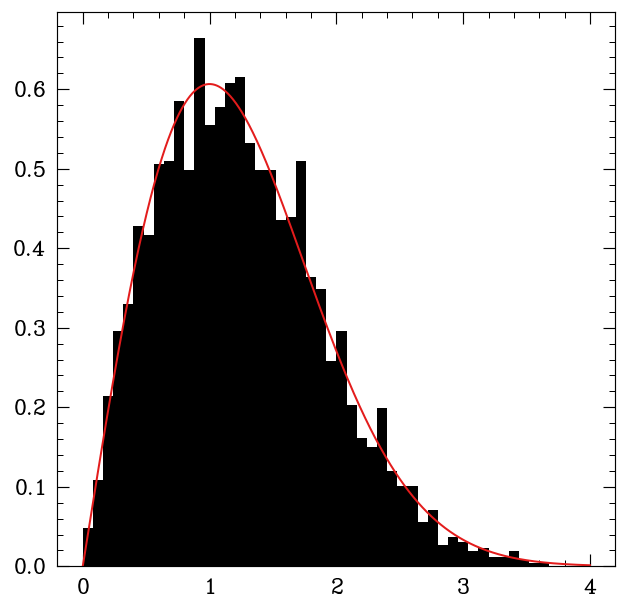

In [54]:
N = 10000
nbins = 50
rmax = 5
r_ = rng_default.uniform(0, rmax, N)
z_ = rng_default.uniform(0, np.max(fr(r_)), N)
cond = z_ < fr(r_)
r_ = r_[cond]
M = len(r_)
plt.hist(r_, bins=nbins, range=(0, 4), density=True)

rr = np.linspace(0, 4, 1000)
plt.plot(rr, fr(rr)/F(rmax)*2*np.pi)

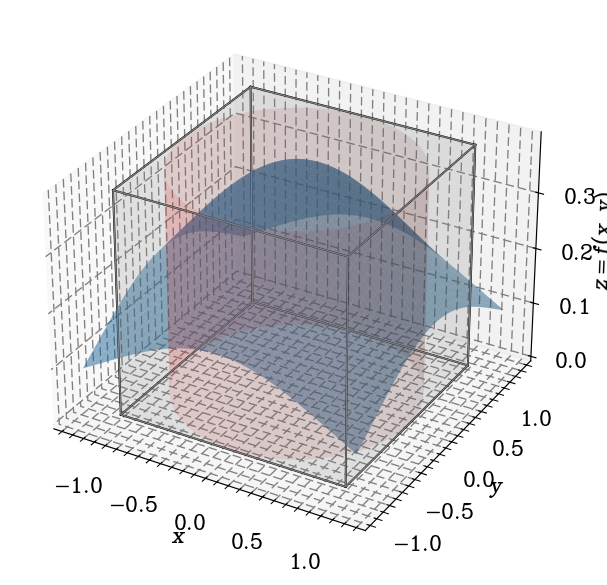

In [13]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-1.2, 1.2, 1000)
y = np.linspace(-1.2, 1.2, 1000)
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, f(X, Y), color='tab:blue', alpha=0.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z=f(x,y)$')

# Define box limits
x_min, x_max = -1, 1
y_min, y_max = -1, 1
z_min, z_max = 0, np.max(f(X, Y))  # Adjust z range as needed

# Define box vertices
vertices = np.array([
    [x_min, y_min, z_min], [x_max, y_min, z_min], [x_max, y_max, z_min], [x_min, y_max, z_min],  # Bottom face
    [x_min, y_min, z_max], [x_max, y_min, z_max], [x_max, y_max, z_max], [x_min, y_max, z_max]   # Top face
])

# Define box edges
edges = [
    [vertices[0], vertices[1]], [vertices[1], vertices[2]], [vertices[2], vertices[3]], [vertices[3], vertices[0]],  # Bottom
    [vertices[4], vertices[5]], [vertices[5], vertices[6]], [vertices[6], vertices[7]], [vertices[7], vertices[4]],  # Top
    [vertices[0], vertices[4]], [vertices[1], vertices[5]], [vertices[2], vertices[6]], [vertices[3], vertices[7]]   # Sides
]

# Draw box edges
for edge in edges:
    ax.plot3D(*zip(*edge), color="black")

# Optional: Fill box faces with transparency
faces = [
    [vertices[j] for j in [0, 1, 5, 4]], [vertices[j] for j in [1, 2, 6, 5]], 
    [vertices[j] for j in [2, 3, 7, 6]], [vertices[j] for j in [3, 0, 4, 7]], 
    [vertices[j] for j in [0, 1, 2, 3]], [vertices[j] for j in [4, 5, 6, 7]]
]
ax.add_collection3d(Poly3DCollection(faces, color='gray', alpha=0.1, linewidths=0.5))


# Define cylinder parameters
r = 1  # Cylinder radius
h_min, h_max = 0, z_max  # Cylinder height range
theta = np.linspace(0, 2 * np.pi, 50)  # Angle
z = np.linspace(h_min, h_max, 50)  # Height
Theta, Zc = np.meshgrid(theta, z)

# Convert cylindrical to Cartesian coordinates
Xc = r * np.cos(Theta) + 0  # Shift center (change '+ 0' if needed)
Yc = r * np.sin(Theta) + 0  # Shift center (change '+ 0' if needed)

# Plot the cylinder
ax.plot_surface(Xc, Yc, Zc, color='r', alpha=0.1)

In [37]:
def Integrate2D_cart(f_, N, rng=rng_default, rmax=1.0,
                xmin=-1.0, xmax=1.0, ymin=-1.0, ymax=1.0, zmin=0.0, zmax=1.0):
    x_ = rng.uniform(xmin, xmax, N)
    y_ = rng.uniform(ymin, ymax, N)
    z_ = rng.uniform(zmin, zmax, N)
    Vbox = (xmax - xmin) * (ymax - ymin) * (zmax - zmin)
    cond1 = np.square(x_) + np.square(y_) < rmax**2
    cond2 = z_ <= f_(x_, y_)
    cond = np.logical_and(cond1, cond2)
    count = np.sum(np.where(cond, 1, 0))
    return count / N * Vbox

def Integrate2D_polar(f_, N, rng=rng_default,
                rmin=0.0, rmax=1.0, zmin=0.0, zmax=1.0):
    r_ = rng.uniform(rmin, rmax, N)
    r2_ = rng.uniform(rmin, rmax, N)
    cond2 = r2_ < r_
    r_ = r_[cond2]
    M = len(r_)

    Vbox = np.pi*rmax**2*(zmax-zmin)
    z_ = rng.uniform(zmin, zmax, M)
    cond = z_ <= f_(r_, 0.0)
    count = np.sum(np.where(cond, 1, 0))
    return count / M * Vbox

def Integrate2D_polar_var(f_, N, rng=rng_default,
                rmin=0.0, rmax=1.0, zmin=0.0, zmax=1.0):
    r_ = np.sqrt(rng.uniform(0.0, 1.0, N))*rmax
    Vbox = np.pi*rmax**2*(zmax-zmin)
    z_ = rng.uniform(zmin, zmax, N)
    cond = z_ <= f(r_, 0.0)
    count = np.sum(np.where(cond, 1, 0))
    return count / N * Vbox

def Integrate2D_polar_var2(f_, N, rng=rng_default,
                rmin=0.0, rmax=1.0, zmin=0.0, zmax=1.0):
    r_ = rng.uniform(rmin, rmax, N)
    z2_ = rng.uniform(rmin, zmax, N)
    cond2 = z2_ < fr(r_)
    r_ = r_[cond2]
    M = len(r_)
    return M / N *rmax*zmax * 2*np.pi

In [40]:
rmax = 1.0
xmin = -rmax
xmax = rmax
ymin = -rmax
ymax = rmax
zmin = 0.0
zmax = f(0,0)
r = np.linspace(0, rmax*1.1, 1000)
zmax2 = np.max(fr(r))
N = 100000000

start = time.time()
print("Exact = ", F(rmax))
print("Aprox. cart = ", Integrate2D_cart(f, N, rmax=rmax, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, zmin=zmin, zmax=zmax))
end = time.time()
print(end-start)

start = time.time()
print("Aprox. polar = ", Integrate2D_polar(f, N, rmax=rmax, zmax=zmax))
end = time.time()
print(end-start)

start = time.time()
print("Aprox. polar_var = ", Integrate2D_polar_var(f, N, rmax=rmax, zmax=zmax))
end = time.time()
print(end-start)
start = time.time()
print("Aprox. polar_var2 = ", Integrate2D_polar_var2(f, N, rmax=rmax, zmax=zmax2))
end = time.time()
print(end-start)

Exact =  0.9862813735647196
Aprox. cart =  0.9862937496641548
2.6074118614196777
Aprox. polar =  0.9862080726724245
1.993204116821289
Aprox. polar =  0.9862633000545385
1.708096981048584
Aprox. polar =  0.9863821015559321
1.8913521766662598


5 0.0 0.3989422804014327
2.507551703463205


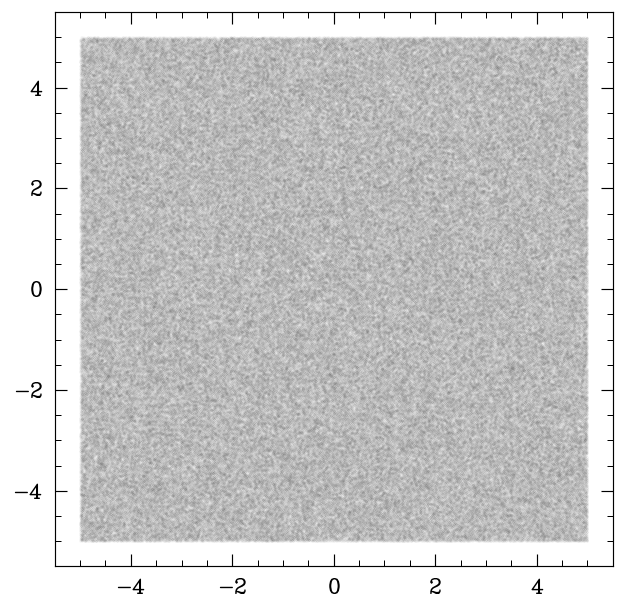

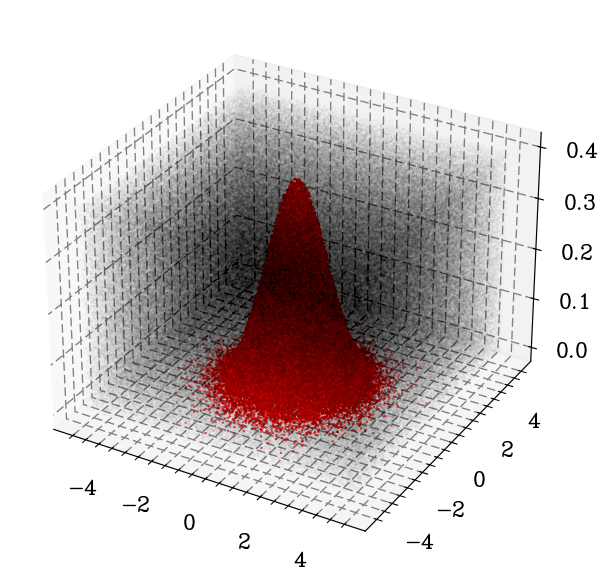

In [62]:
N = 1000000
x_ = rng_default.uniform(-rmax, rmax, N)
y_ = rng_default.uniform(-rmax, rmax, N)
z_ = rng_default.uniform(zmin, zmax, N)

plt.scatter(x_, y_, s=0.1, alpha=0.02)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_, y_, z_, s=0.1, alpha=0.02)

cond1 = x_**2 + y_**2 < rmax**2
cond2 = z_ <= f(x_, y_)
cond = np.logical_and(cond1, cond2)
ax.scatter(x_[cond], y_[cond], z_[cond], s=0.1, color='r')
Vbox = (2*rmax)**2*zmax
print(len(z_[cond])/N*Vbox)

2.516022023598888


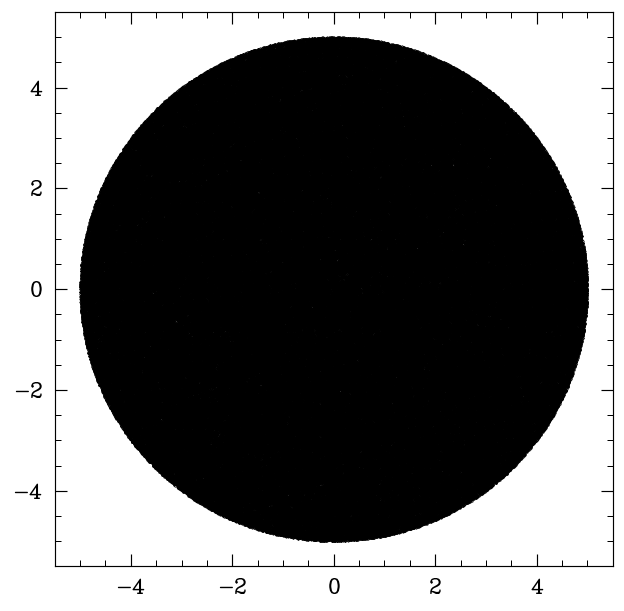

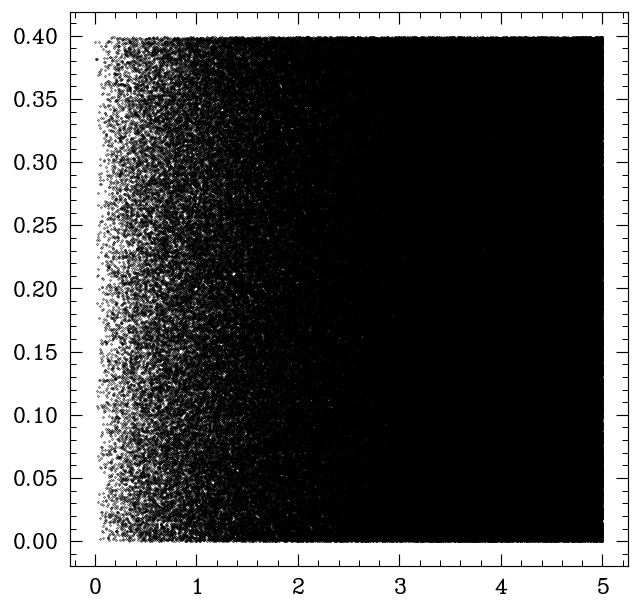

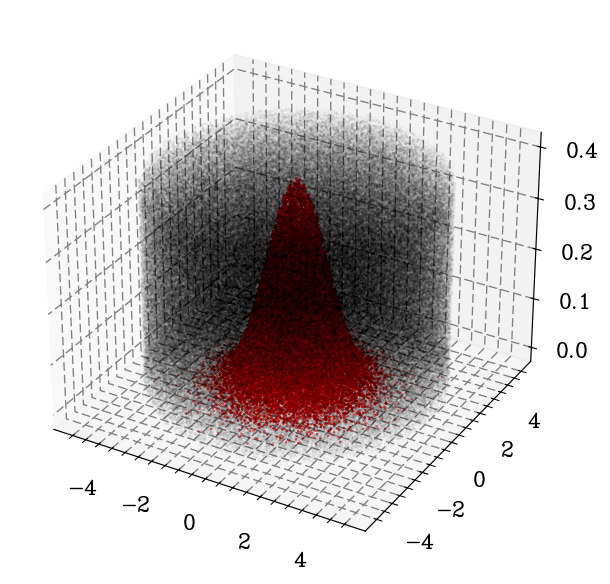

In [60]:
N = 1000000
r_ = rng_default.uniform(0, rmax, N)

z_ = rng_default.uniform(0, rmax, N)
th_ = rng_default.uniform(0, 2*np.pi, N)
cond = z_ < r_
x_ = r_[cond]*np.cos(th_[cond])
y_ = r_[cond]*np.sin(th_[cond])
plt.scatter(x_, y_, s=0.1)

zz = rng_default.uniform(zmin, zmax, len(r_[cond]))
fig, ax = plt.subplots()
ax.scatter(r_[cond], zz, s=0.1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_, y_, zz, s=0.1, alpha=0.05)

cond = zz < f(x_, y_)
ax.scatter(x_[cond], y_[cond], zz[cond], s=0.1, color='r')
print(len(zz[cond])/len(zz)*np.pi*rmax**2*zmax)

### 2) List the approximated values An obtained using n points, as well as the fractional errors: $(A_n- A_0)/ A_0$, where $A_0$ is the exact value.

### 3) Make a plot of the fractional error as a function of n

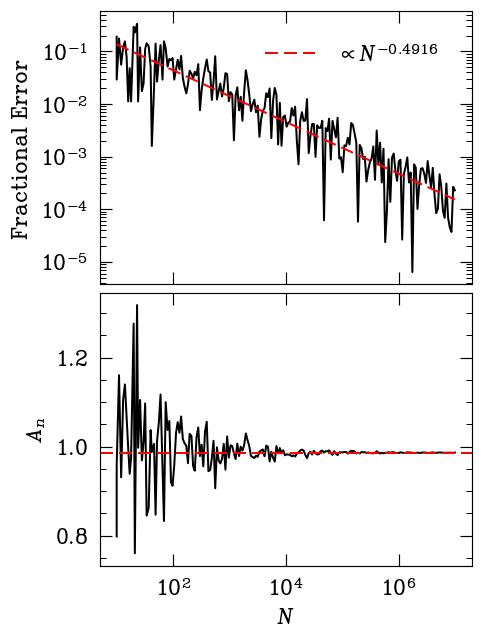

In [69]:
rmax = 1.0
xmin = -rmax
xmax = rmax
ymin = -rmax
ymax = rmax
zmin = 0.0
zmax = f(0,0)
r = np.linspace(0, rmax, 100)
zmax2 = np.max(fr(r))

N = np.geomspace(10, 1e7, 200, dtype=np.int32)
An = np.zeros(len(N))
# An2 = np.zeros(len(N))
# An3 = np.zeros(len(N))
# An4 = np.zeros(len(N))
for i, n in enumerate(N):
    An[i] = Integrate2D_cart(f, n, rmax=rmax, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, zmin=zmin, zmax=zmax)
    # An2[i] = Integrate2D_polar(f, n, rmax=rmax, zmax=zmax)
    # An3[i] = Integrate2D_polar_var(f, n, rmax=rmax, zmax=zmax)
    # An4[i] = Integrate2D_polar_var2(f, n, rmax=rmax, zmax=zmax2)
FE = np.abs(An-ExactInt)/ExactInt
# FE2 = np.abs(An2-ExactInt)/ExactInt
# FE3 = np.abs(An3-ExactInt)/ExactInt
# FE4 = np.abs(An4-ExactInt)/ExactInt

def logFE_fit(logN, A, alpha):
    return A - alpha * logN

popt, pcov = curve_fit(logFE_fit, np.log(N), np.log(FE))

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(4, 6))

axes[0].set_ylabel('Fractional Error')
axes[0].loglog(N, FE)
# axes[0].loglog(N, FE2)
# axes[0].loglog(N, FE3)
# axes[0].loglog(N, FE4)
axes[0].loglog(N, np.exp(logFE_fit(np.log(N), *popt)), ls='--', c='r', label=r'$\propto N^{' + "{:.4f}".format(-popt[1]) + '}$')

axes[1].set_xlabel(r'$N$')
axes[1].set_ylabel(r'$A_n$')
axes[1].semilogx(N, An)
# axes[1].semilogx(N, An2)
# axes[1].semilogx(N, An3)
# axes[1].semilogx(N, An4)
axes[1].axhline(ExactInt, ls='--', c='r')

axes[0].legend()
plt.subplots_adjust(hspace=0.03)